48/48 [==============================] - 0s 3ms/step
Best Hyperparameters for RNN: {'batch_size': 32, 'dropout_rate': 0.6, 'epochs': 100, 'units': 32}
Mean Squared Error (RNN): 0.08617476993535385
Epoch 1/100
154/154 [==============================] - 2s 6ms/step - loss: 0.2911 - val_loss: 0.0937
Epoch 2/100
154/154 [==============================] - 1s 4ms/step - loss: 0.1586 - val_loss: 0.0875
Epoch 3/100
154/154 [==============================] - 1s 5ms/step - loss: 0.1249 - val_loss: 0.0850
Epoch 4/100
154/154 [==============================] - 1s 4ms/step - loss: 0.1101 - val_loss: 0.0853
Epoch 5/100
154/154 [==============================] - 1s 5ms/step - loss: 0.1017 - val_loss: 0.0844
Epoch 6/100
154/154 [==============================] - 1s 5ms/step - loss: 0.0983 - val_loss: 0.0851
Epoch 7/100
154/154 [==============================] - 1s 4ms/step - loss: 0.0944 - val_loss: 0.0848
Epoch 8/100
154/154 [==============================] - 1s 4ms/step - loss: 0.0930 - val_loss: 0.

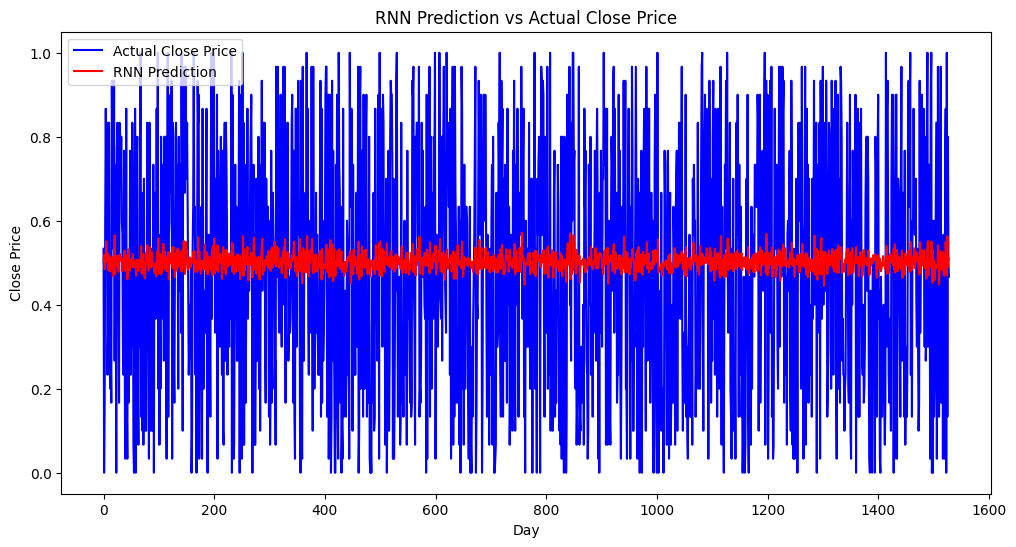

48/48 [==============================] - 1s 5ms/step
Best Hyperparameters for LSTM: {'batch_size': 128, 'epochs': 50, 'units': 128}
Mean Squared Error (LSTM): 0.0865975485477379
Epoch 1/50
39/39 [==============================] - 4s 41ms/step - loss: 0.1236 - val_loss: 0.0885
Epoch 2/50
39/39 [==============================] - 1s 27ms/step - loss: 0.0902 - val_loss: 0.0854
Epoch 3/50
39/39 [==============================] - 1s 27ms/step - loss: 0.0890 - val_loss: 0.0854
Epoch 4/50
39/39 [==============================] - 1s 28ms/step - loss: 0.0885 - val_loss: 0.0849
Epoch 5/50
39/39 [==============================] - 1s 28ms/step - loss: 0.0886 - val_loss: 0.0845
Epoch 6/50
39/39 [==============================] - 2s 39ms/step - loss: 0.0882 - val_loss: 0.0851
Epoch 7/50
39/39 [==============================] - 2s 40ms/step - loss: 0.0878 - val_loss: 0.0843
Epoch 8/50
39/39 [==============================] - 1s 25ms/step - loss: 0.0874 - val_loss: 0.0844
Epoch 9/50
39/39 [============

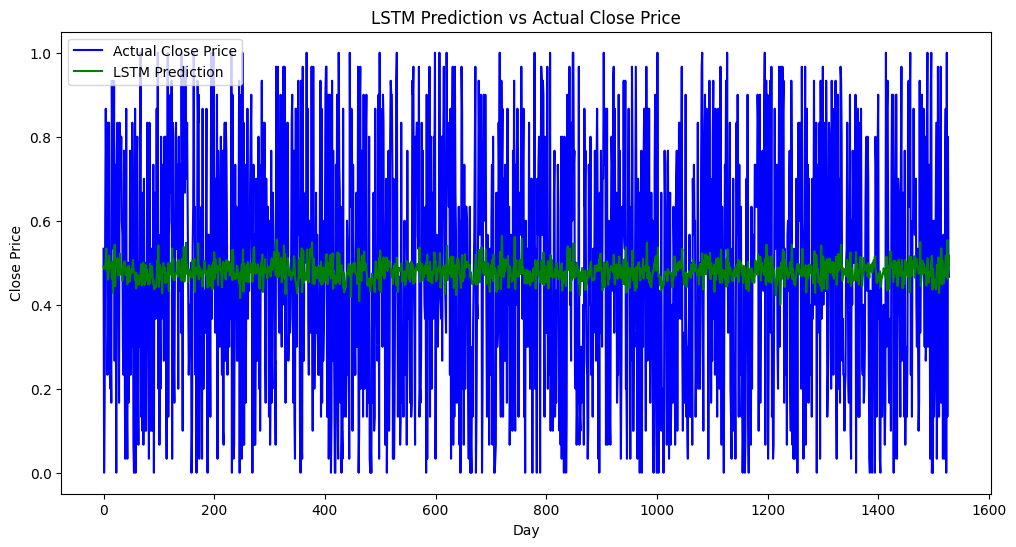

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

df = pd.read_csv('spy.csv')
target_column = 'Close'

# Extract relevant features for modeling
features = ['Open', 'High', 'Low', 'Volume', 'Day', 'Weekday', 'Week', 'Month', 'Year', target_column]
data = df[features]

# Split the data into features (X) and target (y)
X = data.drop(columns=[target_column])
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create patterns for RNN and LSTM
def create_patterns(data, steps=7):
    x_patterns, y_price = [], []
    for day in range(steps, len(data)):
        x_patterns.append(data.iloc[day-steps:day, :].values)
        y_price.append(data.iloc[day, -1])

    x_patterns, y_price = np.array(x_patterns), np.array(y_price)
    return x_patterns, y_price

# Assuming 'steps' is the number of previous days used for prediction
steps = 7
x_train_rnn, y_train_rnn = create_patterns(pd.DataFrame(X_train_scaled), steps)
x_test_rnn, y_test_rnn = create_patterns(pd.DataFrame(X_test_scaled), steps)

# Define hyperparameter grid for RNN
param_grid_rnn = {
    'units': [32, 64, 128],
    'dropout_rate': [0.2, 0.4, 0.6],
    'epochs': [50, 100, 150],
    'batch_size': [32, 64, 128]
}

# Perform hyperparameter tuning for RNN
best_mse_rnn = float('inf')
best_params_rnn = None

for params in ParameterGrid(param_grid_rnn):
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(units=params['units'], activation='tanh', input_shape=(x_train_rnn.shape[1], x_train_rnn.shape[2])))
    model_rnn.add(Dropout(params['dropout_rate']))
    model_rnn.add(Dense(units=1))

    model_rnn.compile(optimizer='adam', loss='mean_squared_error')
    history_rnn = model_rnn.fit(x_train_rnn, y_train_rnn, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2, verbose=0)

    y_pred_rnn = model_rnn.predict(x_test_rnn)
    mse_rnn = mean_squared_error(y_test_rnn, y_pred_rnn)

    if mse_rnn < best_mse_rnn:
        best_mse_rnn = mse_rnn
        best_params_rnn = params

# Print best hyperparameters for RNN
print(f'Best Hyperparameters for RNN: {best_params_rnn}')
print(f'Mean Squared Error (RNN): {best_mse_rnn}')

# Visualize RNN predictions with the best hyperparameters
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=best_params_rnn['units'], activation='tanh', input_shape=(x_train_rnn.shape[1], x_train_rnn.shape[2])))
model_rnn.add(Dropout(best_params_rnn['dropout_rate']))
model_rnn.add(Dense(units=1))

model_rnn.compile(optimizer='adam', loss='mean_squared_error')
history_rnn = model_rnn.fit(x_train_rnn, y_train_rnn, epochs=best_params_rnn['epochs'], batch_size=best_params_rnn['batch_size'], validation_split=0.2, verbose=1)

y_pred_rnn = model_rnn.predict(x_test_rnn)

# Visualize RNN predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_rnn, label='Actual Close Price', color='blue')
plt.plot(y_pred_rnn, label='RNN Prediction', color='red')
plt.title('RNN Prediction vs Actual Close Price')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Define hyperparameter grid for LSTM
param_grid_lstm = {
    'units': [32, 64, 128],
    'epochs': [50, 100, 150],
    'batch_size': [32, 64, 128]
}

# Perform hyperparameter tuning for LSTM
best_mse_lstm = float('inf')
best_params_lstm = None

for params in ParameterGrid(param_grid_lstm):
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=params['units'], input_shape=(x_train_rnn.shape[1], x_train_rnn.shape[2])))
    model_lstm.add(Dense(units=1))

    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    history_lstm = model_lstm.fit(x_train_rnn, y_train_rnn, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2, verbose=0)

    y_pred_lstm = model_lstm.predict(x_test_rnn)
    mse_lstm = mean_squared_error(y_test_rnn, y_pred_lstm)

    if mse_lstm < best_mse_lstm:
        best_mse_lstm = mse_lstm
        best_params_lstm = params

# Print best hyperparameters for LSTM
print(f'Best Hyperparameters for LSTM: {best_params_lstm}')
print(f'Mean Squared Error (LSTM): {best_mse_lstm}')

# Visualize LSTM predictions with the best hyperparameters
model_lstm = Sequential()
model_lstm.add(LSTM(units=best_params_lstm['units'], input_shape=(x_train_rnn.shape[1], x_train_rnn.shape[2])))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = model_lstm.fit(x_train_rnn, y_train_rnn, epochs=best_params_lstm['epochs'], batch_size=best_params_lstm['batch_size'], validation_split=0.2, verbose=1)

y_pred_lstm = model_lstm.predict(x_test_rnn)

# Visualize LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_rnn, label='Actual Close Price', color='blue')
plt.plot(y_pred_lstm, label='LSTM Prediction', color='green')
plt.title('LSTM Prediction vs Actual Close Price')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Dense

# Assume you have loaded your data into a DataFrame called 'df'

# Function to scale data
def scale_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(np.array(data).reshape(-1, 1))
    return data_scaled, scaler

# Function to create patterns and target prices
def create_pattern_set(data_scaled, steps=7):
    x_pattern, y_price = [], []
    for day in range(steps, data_scaled.shape[0]):
        row = data_scaled[day - steps:day, 0]
        x_pattern.append(row)
        y = data_scaled[day, 0]
        y_price.append(y)

    x_pattern, y_price = np.array(x_pattern), np.array(y_price)
    x_pattern = x_pattern.reshape(x_pattern.shape[0], x_pattern.shape[1], 1)
    return x_pattern, y_price

# Assume df is your DataFrame with 'Close' column
data_target = df['Close']

# Scale the data and create patterns for RNN
data_scaled, scaler = scale_data(data_target)
x_train_rnn, y_train_rnn = create_pattern_set(data_scaled)

# Create patterns for LSTM
data_scaled, scaler = scale_data(data_target)
x_train_lstm, y_train_lstm = create_pattern_set(data_scaled)

# Build and train RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, input_shape=(x_train_rnn.shape[1], 1)))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units=1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(x_train_rnn, y_train_rnn, epochs=50, batch_size=32)

# Build and train LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, input_shape=(x_train_lstm.shape[1], 1)))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(x_train_lstm, y_train_lstm, epochs=50, batch_size=32)

# Evaluate RNN
loss_rnn = model_rnn.evaluate(x_train_rnn, y_train_rnn)
print("RNN Loss:", loss_rnn)

# Evaluate LSTM
loss_lstm = model_lstm.evaluate(x_train_lstm, y_train_lstm)
print("LSTM Loss:", loss_lstm)

# Visualize RNN predictions
predictions_rnn = model_rnn.predict(x_train_rnn)
predictions_rnn = scaler.inverse_transform(predictions_rnn)
original_rnn = scaler.inverse_transform(y_train_rnn.reshape(-1, 1))

plt.plot(original_rnn, label='Original RNN')
plt.plot(predictions_rnn, label='Predicted RNN')
plt.legend()
plt.title('RNN - Original vs Predicted')
plt.show()

# Visualize LSTM predictions
predictions_lstm = model_lstm.predict(x_train_lstm)
predictions_lstm = scaler.inverse_transform(predictions_lstm)
original_lstm = scaler.inverse_transform(y_train_lstm.reshape(-1, 1))

plt.plot(original_lstm, label='Original LSTM')
plt.plot(predictions_lstm, label='Predicted LSTM')
plt.legend()
plt.title('LSTM - Original vs Predicted')
plt.show()

# Print model summaries
print("RNN Model Summary:")
model_rnn.summary()

print("LSTM Model Summary:")
model_lstm.summary()
